In [ ]:
# Pls use the corresponding ucf-dataset from https://www.kaggle.com/datasets/odins0n/ucf-crime-dataset/data before using this

In [4]:
import os
import cv2
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, cohen_kappa_score, matthews_corrcoef
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional, GRU, Conv1D, MaxPooling1D, Input
from sklearn.utils import resample

In [2]:
def read_images_from_folder(folder_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder_path))

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_path):
            if img_name.endswith('.png'):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    images.append(img)
                    labels.append([class_name, f"class{np.random.randint(1, 3)}"])

    return images, labels, class_names

In [3]:
def apply_dwt(img):
    img = cv2.resize(img, (64, 64))
    coeffs2 = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs2
    cA = cv2.resize(cA, (4, 4))
    return cA

vgg19 = VGG19(include_top=False, weights='imagenet')
style_layers = ['block1_conv1']
style_model = tf.keras.Model(
    inputs=vgg19.input,
    outputs=[vgg19.get_layer(layer).output for layer in style_layers]
)

def apply_nst(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    img_rgb = np.expand_dims(img_rgb, axis=0) / 255.0
    img_rgb = tf.keras.applications.vgg19.preprocess_input(img_rgb)

    features = style_model(img_rgb)
    flattened_features = [tf.reshape(feature, [-1]) for feature in features]
    concatenated_features = tf.concat(flattened_features, axis=0).numpy()

    # Apply global average pooling to reduce dimensionality
    pooled_features = tf.reduce_mean(concatenated_features, axis=0, keepdims=True).numpy()

    return pooled_features.flatten()


def apply_dwt_merge(cA, cH, cV, cD):
    merged_img = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return merged_img


In [4]:
def process_folder_dataset(folder_path, batch_size=2):
    images, labels, class_names = read_images_from_folder(folder_path)
    processed_data = []

    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        batch_features = []
        for img in batch_images:
            cA = apply_dwt(img)
            nst_features = apply_nst(img)
            merged_features = np.concatenate([cA.flatten(), nst_features]).astype(np.float32)
            batch_features.append(merged_features)

        processed_data.extend(batch_features)

    return np.array(processed_data), np.array(labels), class_names

In [5]:
train_folder = r"C:\Users\KIIT\Desktop\New folder\Minor Project\Train"
test_folder = r"C:\Users\KIIT\Desktop\New folder\Minor Project\Test"

X_train, y_train, class_labels = process_folder_dataset(train_folder)
X_test, y_test, _ = process_folder_dataset(test_folder)

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

num_classes = len(class_labels)
print(f"Training Data Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, Labels: {y_test.shape}")


Training Data Shape: (1131836, 17), Labels: (1131836, 11)
Testing Data Shape: (98529, 17), Labels: (98529, 11)


In [6]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    hamming = hamming_loss(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='weighted')
    support = np.sum(y_true, axis=0)
    kappa_scores = []
    mcc_scores = []
    for i in range(y_true.shape[1]):
        kappa = cohen_kappa_score(y_true[:, i], y_pred[:, i])
        mcc = matthews_corrcoef(y_true[:, i], y_pred[:, i])
        kappa_scores.append(kappa)
        mcc_scores.append(mcc)

    avg_kappa = np.mean(kappa_scores)
    avg_mcc = np.mean(mcc_scores)

    return accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support

In [7]:
def naive_bayes_classifier(X_train, y_train, X_test, y_test):
    model = MultiOutputClassifier(GaussianNB())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("Naive Bayes Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")

In [9]:
def decision_tree_classifier(X_train, y_train, X_test, y_test):
    model = MultiOutputClassifier(DecisionTreeClassifier())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("Decision Tree Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")


In [10]:
def random_forest_classifier(X_train, y_train, X_test, y_test):
    model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("Random Forest Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")


In [11]:
def knn_classifier(X_train, y_train, X_test, y_test):
    model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("KNN Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")


In [40]:
def svm_classifier(X_train, y_train, X_test, y_test, max_samples_per_class=1000, test_size=100):
    if len(X_test) > test_size:
        indices = np.random.choice(len(X_test), test_size, replace=False)
        X_test = X_test[indices]
        y_test = y_test[indices]
    
    unique_classes = np.unique(y_train.argmax(axis=1))
    sampled_indices = []
    
    for cls in unique_classes:
        cls_indices = np.where(y_train.argmax(axis=1) == cls)[0]
        if len(cls_indices) > max_samples_per_class:
            cls_indices = resample(cls_indices, 
                                 n_samples=max_samples_per_class,
                                 replace=False,
                                 random_state=42)
        sampled_indices.extend(cls_indices)
    
    X_train = X_train[sampled_indices]
    y_train = y_train[sampled_indices]
    
    model = MultiOutputClassifier(
        SVC(kernel='linear', 
            probability=True, 
            decision_function_shape='ovr',
            cache_size=1000),  
        n_jobs=-1  # Use all CPU cores
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("SVM Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa: {avg_kappa:.4f}, MCC: {avg_mcc:.4f}")
    print(f"Support: {support}")

In [12]:
def ann_classifier(X_train, y_train, X_test, y_test):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
    y_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold predictions
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("ANN Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")

In [13]:
def cnn_classifier(X_train, y_train, X_test, y_test):
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(y_train.shape[1], activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_split=0.2)
    y_pred = (model.predict(X_test_cnn) > 0.5).astype(int)  # Threshold predictions
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("CNN Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")


In [14]:
def lstm_classifier(X_train, y_train, X_test, y_test):
    X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    model = Sequential([
        LSTM(128, input_shape=(X_train.shape[1], 1)),
        Dense(y_train.shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2)
    y_pred = (model.predict(X_test_lstm) > 0.5).astype(int)  # Threshold predictions
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("LSTM Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")


In [15]:
def bilstm_classifier(X_train, y_train, X_test, y_test):
    X_train_bilstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_bilstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    model = Sequential([
        Bidirectional(LSTM(128, input_shape=(X_train.shape[1], 1))),
        Dense(y_train.shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_bilstm, y_train, epochs=20, batch_size=32, validation_split=0.2)
    y_pred = (model.predict(X_test_bilstm) > 0.5).astype(int)  # Threshold predictions
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("BiLSTM Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")


In [16]:
def gru_classifier(X_train, y_train, X_test, y_test):
    X_train_gru = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_gru = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    model = Sequential([
        GRU(128, input_shape=(X_train.shape[1], 1)),
        Dense(y_train.shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_gru, y_train, epochs=20, batch_size=32, validation_split=0.2)
    y_pred = (model.predict(X_test_gru) > 0.5).astype(int)
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("GRU Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")


In [17]:
def bigru_classifier(X_train, y_train, X_test, y_test):
    X_train_bigru = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_bigru = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    model = Sequential([
        Bidirectional(GRU(128, input_shape=(X_train.shape[1], 1))),
        Dense(y_train.shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_bigru, y_train, epochs=20, batch_size=32, validation_split=0.2)
    y_pred = (model.predict(X_test_bigru) > 0.5).astype(int)  # Threshold predictions
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    print("BiGRU Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")

In [19]:
def autoencoder_feature_extraction(X_train, X_test, encoding_dim=64):
    input_dim = X_train.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    autoencoder.fit(X_train, X_train,
                   epochs=50,
                   batch_size=256,
                   shuffle=True,
                   validation_data=(X_test, X_test),
                   verbose=0)
    
    encoder_model = Model(inputs=input_layer, outputs=encoder)
    
    X_train_encoded = encoder_model.predict(X_train)
    X_test_encoded = encoder_model.predict(X_test)
    
    return X_train_encoded, X_test_encoded

def autoencoder_classifier(X_train, y_train, X_test, y_test):
    X_train_encoded, X_test_encoded = autoencoder_feature_extraction(X_train, X_test)
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_encoded.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])
    
    history = model.fit(X_train_encoded, y_train,
                       epochs=20,
                       batch_size=32,
                       validation_split=0.2,
                       verbose=0)
    
    y_pred = (model.predict(X_test_encoded) > 0.5).astype(int)
    
    accuracy, precision, recall, f1, hamming, jaccard, avg_kappa, avg_mcc, support = calculate_metrics(y_test, y_pred)
    
    print("AutoEncoder Classifier:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Hamming Loss: {hamming:.4f}, Jaccard Score: {jaccard:.4f}")
    print(f"Cohen's Kappa (Average): {avg_kappa:.4f}, MCC (Average): {avg_mcc:.4f}")
    print(f"Support: {support}")

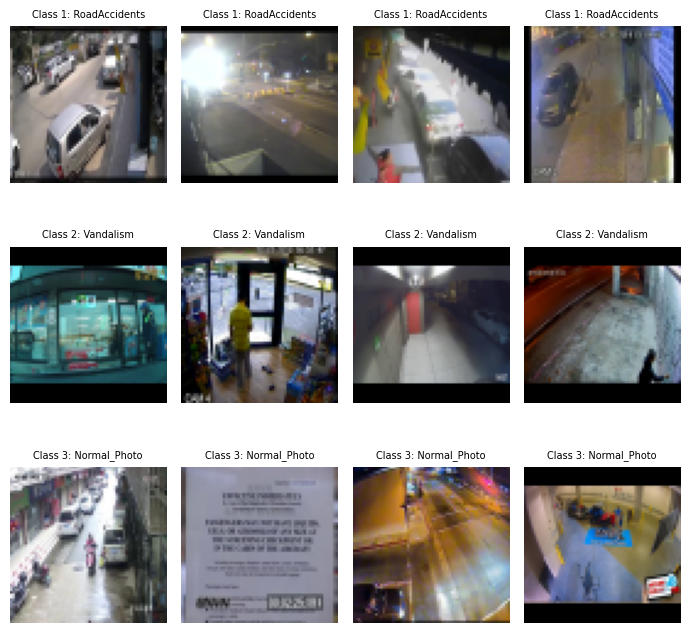

In [16]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def display_sample_images(folder_paths, num_images, title_fontsize=7):
    plt.figure(figsize=(7, 7))
    
    for i, folder_path in enumerate(folder_paths, 1):
        image_files = [f for f in os.listdir(folder_path) 
                      if f.lower().endswith(('.png'))]
        
        sample_images = random.sample(image_files, min(num_images, len(image_files)))
        
        for j, img_file in enumerate(sample_images, 1):
            plt.subplot(3, num_images, (i-1)*num_images + j)
            img = Image.open(os.path.join(folder_path, img_file))
            plt.imshow(img)
            plt.title(f"Class {i}: {os.path.basename(folder_path)}", fontsize=title_fontsize)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

class_folders = [
    r"C:\Users\KIIT\Desktop\New folder\Minor Project\Train\RoadAccidents",
    r"C:\Users\KIIT\Desktop\New folder\Minor Project\Train\Vandalism", 
    r"C:\Users\KIIT\Desktop\New folder\Minor Project\Train\Normal_Photo"
]

display_sample_images(class_folders, num_images=4)

In [12]:
naive_bayes_classifier(X_train, y_train, X_test, y_test)

Naive Bayes Classifier:
Accuracy: 0.2108, Precision: 0.4963, Recall: 0.5573, F1: 0.5210
Hamming Loss: 0.2008, Jaccard Score: 0.3839
Cohen's Kappa (Average): 0.0418, MCC (Average): 0.0429
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49365 49164]


In [27]:
decision_tree_classifier(X_train, y_train, X_test, y_test)

Decision Tree Classifier:
Accuracy: 0.2035, Precision: 0.4979, Recall: 0.5152, F1: 0.5020
Hamming Loss: 0.1702, Jaccard Score: 0.3617
Cohen's Kappa (Average): 0.0319, MCC (Average): 0.0345
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49365 49164]


In [28]:
random_forest_classifier(X_train, y_train, X_test, y_test)

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Classifier:
Accuracy: 0.1682, Precision: 0.4827, Recall: 0.5469, F1: 0.5006
Hamming Loss: 0.1529, Jaccard Score: 0.3728
Cohen's Kappa (Average): 0.0086, MCC (Average): 0.0205
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49365 49164]


In [29]:
knn_classifier(X_train, y_train, X_test, y_test)

KNN Classifier:
Accuracy: 0.2611, Precision: 0.5030, Recall: 0.5101, F1: 0.5032
Hamming Loss: 0.1748, Jaccard Score: 0.3671
Cohen's Kappa (Average): 0.0336, MCC (Average): 0.0345
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49365 49164]


In [64]:
ann_classifier(X_train, y_train, X_test, y_test)

Epoch 1/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 171s 6ms/step - accuracy: 0.8948 - loss: 0.2620 - val_accuracy: 0.5925 - val_loss: 1.1628
Epoch 2/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 169s 6ms/step - accuracy: 0.9209 - loss: 0.1700 - val_accuracy: 0.5933 - val_loss: 1.9937
Epoch 3/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 169s 6ms/step - accuracy: 0.9289 - loss: 0.1638 - val_accuracy: 0.5894 - val_loss: 2.3142
Epoch 4/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 210s 6ms/step - accuracy: 0.9341 - loss: 0.1613 - val_accuracy: 0.5888 - val_loss: 2.6750
Epoch 5/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 176s 6ms/step - accuracy: 0.9365 - loss: 0.1602 - val_accuracy: 0.5927 - val_loss: 3.1463
Epoch 6/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 173s 6ms/step - accuracy: 0.9374 - loss: 0.1593 - val_accuracy: 0.5959 - val_loss: 3.0340
Epoch 7/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 181s 6ms/step - accuracy: 0.9382 - loss: 0.1590 - val_accuracy: 0.5954 - val_loss: 3.4169
Epoch 8/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 176s 6ms/step - ac

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ANN Classifier:
Accuracy: 0.0000, Precision: 0.2390, Recall: 0.3046, F1: 0.2589
Hamming Loss: 0.1536, Jaccard Score: 0.2125
Cohen's Kappa (Average): 0.0088, MCC (Average): 0.0131
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49365 49164]


In [65]:
cnn_classifier(X_train, y_train, X_test, y_test)

Epoch 1/20


C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28296/28296 ━━━━━━━━━━━━━━━━━━━━ 158s 5ms/step - accuracy: 0.9246 - loss: 0.1794 - val_accuracy: 0.5830 - val_loss: 1.6847
Epoch 2/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 158s 6ms/step - accuracy: 0.9762 - loss: 0.1392 - val_accuracy: 0.5600 - val_loss: 1.9000
Epoch 3/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 241s 9ms/step - accuracy: 0.9804 - loss: 0.1372 - val_accuracy: 0.5726 - val_loss: 1.9339
Epoch 4/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 260s 9ms/step - accuracy: 0.9828 - loss: 0.1361 - val_accuracy: 0.5797 - val_loss: 2.1512
Epoch 5/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 331s 12ms/step - accuracy: 0.9841 - loss: 0.1356 - val_accuracy: 0.5664 - val_loss: 2.1185
Epoch 6/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 272s 10ms/step - accuracy: 0.9850 - loss: 0.1352 - val_accuracy: 0.5711 - val_loss: 2.1805
Epoch 7/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 264s 9ms/step - accuracy: 0.9858 - loss: 0.1349 - val_accuracy: 0.5772 - val_loss: 2.0695
Epoch 8/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 275s 10ms/step - accuracy: 

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CNN Classifier:
Accuracy: 0.2586, Precision: 0.4636, Recall: 0.5194, F1: 0.4759
Hamming Loss: 0.1756, Jaccard Score: 0.3429
Cohen's Kappa (Average): -0.0082, MCC (Average): -0.0102
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49365 49164]


In [20]:
lstm_classifier(X_train, y_train, X_test, y_test)

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 522s 18ms/step - accuracy: 0.9167 - loss: 0.1754 - val_accuracy: 0.5018 - val_loss: 0.9417
Epoch 2/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 516s 18ms/step - accuracy: 0.9552 - loss: 0.1476 - val_accuracy: 0.4905 - val_loss: 1.0465
Epoch 3/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 523s 18ms/step - accuracy: 0.9650 - loss: 0.1425 - val_accuracy: 0.5138 - val_loss: 1.0704
Epoch 4/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 533s 19ms/step - accuracy: 0.9687 - loss: 0.1405 - val_accuracy: 0.4620 - val_loss: 1.1133
Epoch 5/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 553s 20ms/step - accuracy: 0.9732 - loss: 0.1386 - val_accuracy: 0.4962 - val_loss: 1.0917
Epoch 6/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 552s 20ms/step - accuracy: 0.9755 - loss: 0.1376 - val_accuracy: 0.4635 - val_loss: 1.0778
Epoch 7/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 566s 20ms/step - accuracy: 0.9766 - loss: 0.1371 - val_accuracy: 0.5076 - val_loss: 1.0444
Epoch 8/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 586s 21ms/s

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM Classifier:
Accuracy: 0.2946, Precision: 0.4820, Recall: 0.5474, F1: 0.4466
Hamming Loss: 0.1610, Jaccard Score: 0.3400
Cohen's Kappa (Average): 0.0156, MCC (Average): 0.0157
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49199 49330]


In [21]:
bilstm_classifier(X_train, y_train, X_test, y_test)

Epoch 1/20


C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28296/28296 ━━━━━━━━━━━━━━━━━━━━ 712s 25ms/step - accuracy: 0.9221 - loss: 0.1704 - val_accuracy: 0.5129 - val_loss: 1.0605
Epoch 2/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 700s 25ms/step - accuracy: 0.9586 - loss: 0.1459 - val_accuracy: 0.5130 - val_loss: 1.1005
Epoch 3/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 715s 25ms/step - accuracy: 0.9674 - loss: 0.1411 - val_accuracy: 0.5151 - val_loss: 1.0675
Epoch 4/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 721s 25ms/step - accuracy: 0.9727 - loss: 0.1388 - val_accuracy: 0.5119 - val_loss: 1.1122
Epoch 5/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 735s 26ms/step - accuracy: 0.9755 - loss: 0.1376 - val_accuracy: 0.5163 - val_loss: 1.1638
Epoch 6/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 742s 26ms/step - accuracy: 0.9778 - loss: 0.1366 - val_accuracy: 0.4875 - val_loss: 1.1074
Epoch 7/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 747s 26ms/step - accuracy: 0.9792 - loss: 0.1361 - val_accuracy: 0.5267 - val_loss: 1.1345
Epoch 8/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 745s 26ms/step - accur

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


BiLSTM Classifier:
Accuracy: 0.2748, Precision: 0.4752, Recall: 0.5333, F1: 0.4996
Hamming Loss: 0.1639, Jaccard Score: 0.3642
Cohen's Kappa (Average): 0.0228, MCC (Average): 0.0228
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49199 49330]


In [22]:
gru_classifier(X_train, y_train, X_test, y_test)

Epoch 1/20


C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28296/28296 ━━━━━━━━━━━━━━━━━━━━ 543s 19ms/step - accuracy: 0.9169 - loss: 0.1747 - val_accuracy: 0.4934 - val_loss: 0.9932
Epoch 2/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 544s 19ms/step - accuracy: 0.9511 - loss: 0.1503 - val_accuracy: 0.5230 - val_loss: 1.0581
Epoch 3/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 551s 19ms/step - accuracy: 0.9586 - loss: 0.1463 - val_accuracy: 0.4925 - val_loss: 1.1050
Epoch 4/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 556s 20ms/step - accuracy: 0.9615 - loss: 0.1446 - val_accuracy: 0.5562 - val_loss: 1.1174
Epoch 5/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 566s 20ms/step - accuracy: 0.9644 - loss: 0.1433 - val_accuracy: 0.5230 - val_loss: 1.1233
Epoch 6/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 577s 20ms/step - accuracy: 0.9653 - loss: 0.1430 - val_accuracy: 0.5090 - val_loss: 1.1282
Epoch 7/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 573s 20ms/step - accuracy: 0.9664 - loss: 0.1423 - val_accuracy: 0.5265 - val_loss: 1.1168
Epoch 8/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 589s 21ms/step - accur

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GRU Classifier:
Accuracy: 0.2705, Precision: 0.4826, Recall: 0.5247, F1: 0.4858
Hamming Loss: 0.1652, Jaccard Score: 0.3526
Cohen's Kappa (Average): -0.0005, MCC (Average): 0.0042
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49199 49330]


In [23]:
bigru_classifier(X_train, y_train, X_test, y_test)

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 699s 24ms/step - accuracy: 0.9178 - loss: 0.1730 - val_accuracy: 0.4856 - val_loss: 1.0278
Epoch 2/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 713s 25ms/step - accuracy: 0.9513 - loss: 0.1493 - val_accuracy: 0.5514 - val_loss: 1.0444
Epoch 3/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 728s 26ms/step - accuracy: 0.9570 - loss: 0.1464 - val_accuracy: 0.5231 - val_loss: 1.0998
Epoch 4/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 731s 26ms/step - accuracy: 0.9593 - loss: 0.1453 - val_accuracy: 0.4739 - val_loss: 1.0626
Epoch 5/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 738s 26ms/step - accuracy: 0.9601 - loss: 0.1450 - val_accuracy: 0.5336 - val_loss: 1.0662
Epoch 6/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 713s 25ms/step - accuracy: 0.9606 - loss: 0.1447 - val_accuracy: 0.4933 - val_loss: 1.0940
Epoch 7/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 721s 25ms/step - accuracy: 0.9598 - loss: 0.1451 - val_accuracy: 0.5256 - val_loss: 1.1460
Epoch 8/20
28296/28296 ━━━━━━━━━━━━━━━━━━━━ 768s 27ms/s

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


BiGRU Classifier:
Accuracy: 0.2963, Precision: 0.4608, Recall: 0.5485, F1: 0.4213
Hamming Loss: 0.1604, Jaccard Score: 0.3290
Cohen's Kappa (Average): -0.0055, MCC (Average): -0.0078
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49199 49330]


In [24]:
autoencoder_classifier(X_train, y_train, X_test, y_test)

35370/35370 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
3080/3080 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3080/3080 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AutoEncoder Classifier:
Accuracy: 0.3301, Precision: 0.3426, Recall: 0.5799, F1: 0.4289
Hamming Loss: 0.1528, Jaccard Score: 0.3426
Cohen's Kappa (Average): -0.0000, MCC (Average): -0.0002
Support: [ 3365  2657  7657  6510 64952  2663  7630  1984  1111 49199 49330]


In [41]:
svm_classifier(X_train, y_train, X_test, y_test)

SVM Classifier:
Accuracy: 0.0200, Precision: 0.3200, Recall: 0.2850, F1: 0.2667
Hamming Loss: 0.1736, Jaccard Score: 0.1861
Cohen's Kappa: 0.0419, MCC: 0.0503
Support: [ 2  1 11  9 60  4 10  1  2 49 51]


C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
